In [1]:
import numpy as np
import matplotlib.pyplot as plt
import library.volumes.strmesh as vol
import scipy.io as sio
from sklearn.pipeline import Pipeline
from sklearn.kernel_approximation import RBFSampler
from sklearn import mixture
import open3d as o3d

nolineal=1
xfilename='data/curvature/'
gtfilename='data/gt/'
surface1='victoria0'
surface2='victoria1'
components=6
montecarlo=200
gamma=0.01

In [2]:
filename=gtfilename+surface1+'-'+surface2+'.mat'
info=sio.whosmat(filename)[0]
mat=sio.loadmat(filename)
gt=mat[info[0]]-1

In [3]:
filename=xfilename+surface1+'-'+surface2+'.mat'
info=sio.whosmat(filename)[0]
mat=sio.loadmat(filename)
X=mat[info[0]]

In [4]:
#Dir data
base='data/nonrigid3d/'
data=surface1+'.mat'
mesh1=vol.StrMesh(filename=base+data)

!Mesh load complete!
Vertices: 5000
Triangles: 9996


In [5]:
base='data/nonrigid3d/'
data=surface2+'.mat'
mesh2=vol.StrMesh(filename=base+data)

!Mesh load complete!
Vertices: 5000
Triangles: 9996


In [6]:
if nolineal==1:
    #gmm-no lineal
    steps = [('rff', RBFSampler(gamma=gamma,n_components=montecarlo,random_state=48)), 
            ('cluster', mixture.BayesianGaussianMixture(n_components=components, random_state=48))] #clasificador 
    method = Pipeline(steps)
else:
    #gmm lineal
    steps = [ ('cluster', mixture.BayesianGaussianMixture(n_components=components, random_state=48))] #clasificador 
    method = Pipeline(steps) 

In [7]:
method.fit(X)
Z=method.predict(X)

C:\Users\minol\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


In [8]:
tam1=mesh1.vertices.shape[0]
tam2=mesh2.vertices.shape[0]
Z1=Z[0:tam1]
Z2=Z[tam1:]

In [11]:
norm=np.sqrt(mesh2.getArea())
print(norm)

141.07395674649416


In [12]:
import gdist
vertices=mesh2.vertices.astype(np.float64)
triangles = mesh2.triangles.astype(np.int32)
geodist=np.array([])
for i in range(tam1):
    if not(np.isnan(gt[i])):
        print('Vertex number:',i)
        label=Z1[i]
        src=np.array(gt[i],dtype=np.int32)
        trg=np.where(Z2==label)[0].astype(np.int32)
        dist=gdist.compute_gdist(vertices, triangles, source_indices=src, target_indices=trg)
        geodist=np.concatenate((geodist,dist.min(keepdims=True)))#dist.min(keepdims=True)
geodist=geodist/norm

Vertex number: 3484
Vertex number: 3487
Vertex number: 3488
Vertex number: 3489
Vertex number: 3490
Vertex number: 3492
Vertex number: 3494
Vertex number: 3496
Vertex number: 3498
Vertex number: 3501
Vertex number: 3502
Vertex number: 3503
Vertex number: 3505
Vertex number: 3506
Vertex number: 3507
Vertex number: 3508
Vertex number: 3510
Vertex number: 3512
Vertex number: 3515
Vertex number: 3516
Vertex number: 3519
Vertex number: 3520
Vertex number: 3522
Vertex number: 3524
Vertex number: 3525
Vertex number: 3528
Vertex number: 3529
Vertex number: 3531
Vertex number: 3533
Vertex number: 3534
Vertex number: 3537
Vertex number: 3538
Vertex number: 3539
Vertex number: 3543
Vertex number: 3544
Vertex number: 3547
Vertex number: 3551
Vertex number: 3557
Vertex number: 3559
Vertex number: 3562
Vertex number: 3563
Vertex number: 3564
Vertex number: 3566
Vertex number: 3568
Vertex number: 3570
Vertex number: 3575
Vertex number: 3577
Vertex number: 3579
Vertex number: 3583
Vertex number: 3586


In [13]:
step=0.005
thresh = np.arange(0,0.25+step,step)
curve=[]
for i in range(thresh.shape[0]):
    curve.append(100*np.sum(geodist<=thresh[i])/geodist.shape[0])
curve=np.array(curve)

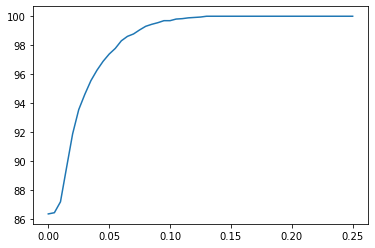

In [14]:
plt.plot(thresh,curve)
plt.show()

In [17]:
index=np.where(curve<=100)
percentage=np.max(curve[index])
ind=np.where(curve==percentage)[0]
error=np.min(thresh[ind])
print('Geodesic Error:',error)
print('Percentage:',percentage)

Geodesic Error: 0.13
Percentage: 100.0


In [9]:
rmin=np.min(Z1)
rmax=np.max(Z1)
mesh1.assignHeatColor(minimum=rmin,maximum=rmax,value=Z1)
rmin=np.min(Z2)
rmax=np.max(Z2)
mesh2.assignHeatColor(minimum=rmin,maximum=rmax,value=Z2)

In [10]:
vis = o3d.visualization.Visualizer()
vis.create_window(window_name='TopLeft', width=960, height=540, left=0, top=400)
vis.add_geometry(mesh1.mesh)

vis2 = o3d.visualization.Visualizer()
vis2.create_window(window_name='TopRight', width=960, height=540, left=960, top=400)
vis2.add_geometry(mesh2.mesh)

while True:
    vis.update_geometry(mesh1.mesh)
    if not vis.poll_events():
        break
    vis.update_renderer()

    vis2.update_geometry(mesh2.mesh)
    if not vis2.poll_events():
        break
    vis2.update_renderer()

vis.destroy_window()
vis2.destroy_window()

In [1]:
import numpy as np

surface1='cat0'
surface2='cat1'
saveruta='resultsgmm-nolineal/geodesicdistance-nonrigid/'+surface1+'-'+surface2+'.txt'
geodist=np.array([3.4,4.5,8.8,9.9])
np.savetxt(saveruta, geodist, fmt='%f')

In [5]:
geodist = np.loadtxt(saveruta, dtype=float)
print(geodist.shape)

(3592,)


In [6]:
step=0.005
thresh = np.arange(0,0.25+step,step)
curve=[]
for i in range(thresh.shape[0]):
    curve.append(100*np.sum(geodist<=thresh[i])/geodist.shape[0])
curve=np.array(curve)

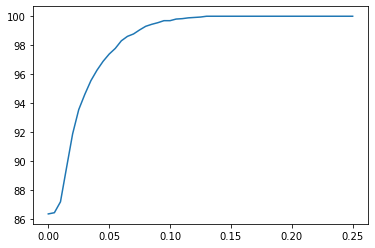

In [9]:
plt.plot(thresh,curve)
plt.show()